In [1]:
# %% [markdown]
# # Environment

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import anndata as ad
import warnings
from celltypist import models, annotate

In [3]:
os.chdir("/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/cell_typist")

In [4]:
# This cell will be parameterized by the script
sel_model = "Mouse_Isocortex_Hippocampus"  # This will be replaced with the actual model name
sel_sample = "Emx1_Ctrl"  # This will be replaced with the actual sample name
print(f"Processing model: {sel_model}, sample: {sel_sample}")

leiden_res_dict = {
    "Emx1_Ctrl": [0.38, 0.3, 0.05],
    "Emx1_Mut": [0.47, 0.38, 0.3],
    "Nestin_Ctrl": [0.05, 0.13, 0.47],
    "Nestin_Mut": [0.47, 0.3, 0.63]
}

leiden_res = leiden_res_dict[sel_sample]

Processing model: Mouse_Isocortex_Hippocampus, sample: Emx1_Ctrl


In [5]:
# Specific mouse brain models available in CellTypist
# https://www.celltypist.org/models
MOUSE_HIPPOCAMPUS_MODELS = {
    "Mouse_Isocortex_Hippocampus": {
        "description": "Cell types from the adult mouse isocortex (neocortex) and hippocampal formation",
        "cell_types": 42,
        "version": "v1",
        "reference": "https://doi.org/10.1016/j.cell.2021.04.021"
    },
    "Mouse_Dentate_Gyrus": {
        "description": "Cell types from the dentate gyrus in perinatal, juvenile, and adult mice",
        "cell_types": 24,
        "version": "v1",
        "reference": "https://doi.org/10.1038/s41593-017-0056-2"
    }
}

In [6]:
# Set up directories
results_dir = f"results_{sel_model}"
model_dir = "models"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [7]:
# DATA dirs
base_path = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis"
outputs_folder = "individual_data_analysis_opt_clusters"
folder_prefix = "cellranger_counts_R26_"
data_dir = os.path.join(base_path, outputs_folder, folder_prefix)

adata_paths = {
    "Emx1_Ctrl": f"{data_dir}Emx1_Ctrl_adult_0/Emx1_Ctrl_processed.h5ad",
    "Emx1_Mut": f"{data_dir}Emx1_Mut_adult_1/Emx1_Mut_processed.h5ad",
    "Nestin_Ctrl": f"{data_dir}Nestin_Ctrl_adult_2/Nestin_Ctrl_processed.h5ad",
    "Nestin_Mut": f"{data_dir}Nestin_Mut_adult_3/Nestin_Mut_processed.h5ad"
}

In [8]:
adata_path = adata_paths[sel_sample]
model_path = f"models/{sel_model}.pkl"

# %% [markdown]
# # Load Data

In [9]:
if adata_path:
    print(f"Loading AnnData from {adata_path}")
    adata = sc.read_h5ad(adata_path)
else:
    # Try to use a global adata object
    try:
        adata = globals()['adata']
        print("Using already loaded AnnData object")
    except KeyError:
        print("No AnnData object provided. Please provide a path to an .h5ad file.")

print(f"AnnData object contains {adata.n_obs} cells and {adata.n_vars} genes")

Loading AnnData from /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/individual_data_analysis_opt_clusters/cellranger_counts_R26_Emx1_Ctrl_adult_0/Emx1_Ctrl_processed.h5ad


AnnData object contains 4707 cells and 26071 genes


In [10]:
model = models.Model.load(model_path)

# %% [markdown]
# # Explore cell annotation model

In [11]:
print(type(model))
print(model.__dict__.keys())
print(model.description)
print(f"Model: {os.path.basename(model_path)}")
print(f"Number of cell types: {len(model.cell_types)}")

<class 'celltypist.models.Model'>
dict_keys(['classifier', 'scaler', 'description'])
{'date': '2023-07-16 14:42:07.696736', 'details': 'cell types from the adult mouse isocortex (neocortex) and hippocampal formation', 'url': 'https://celltypist.cog.sanger.ac.uk/models/Mouse_IsocortexHPF_Yao/v1/Mouse_Isocortex_Hippocampus.pkl', 'source': 'https://doi.org/10.1016/j.cell.2021.04.021', 'version': 'v1', 'number_celltypes': 42}
Model: Mouse_Isocortex_Hippocampus.pkl
Number of cell types: 42


In [12]:
# Inspect all available attributes and methods of the model object
print("Available attributes and methods:")
for attr in dir(model):
    if not attr.startswith('__'):  # Skip dunder methods
        attr_type = type(getattr(model, attr))
        print(f"  - {attr}: {attr_type}")

Available attributes and methods:
  - cell_types: <class 'numpy.ndarray'>
  - classifier: <class 'sklearn.linear_model._logistic.LogisticRegression'>
  - convert: <class 'method'>
  - description: <class 'dict'>
  - extract_top_markers: <class 'method'>
  - features: <class 'numpy.ndarray'>
  - load: <class 'function'>
  - predict_labels_and_prob: <class 'method'>
  - scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
  - write: <class 'method'>


In [13]:
hippo_suffix = ['CA1', 'CA2', 'CA3', 'DG', 'SUB-ProS']
cortical_suffix = ['CTX', 'L2', 'L3', 'L4', 'L5', 'L6']

In [14]:
# Get all cell types
all_cell_types = model.cell_types

# Define hippocampal cell types
hippocampal_cell_types = [ct for ct in all_cell_types if any(h in ct for h in hippo_suffix)]
print("Hippocampal cell types:")
print(hippocampal_cell_types)

# Define cortical cell types (layers and cortical regions)
cortical_cell_types = [ct for ct in all_cell_types if any(c in ct for c in cortical_suffix)]
print("\nCortical cell types:")
print(cortical_cell_types)

# Other cell types
other_cell_types = [ct for ct in all_cell_types if ct not in hippocampal_cell_types and ct not in cortical_cell_types]
print("\nOther cell types:")
print(other_cell_types)

# Display original array for reference
model.cell_types

Hippocampal cell types:
['CA1-ProS', 'CA2-IG-FC', 'CA3', 'DG', 'SUB-ProS']

Cortical cell types:
['L2 IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX', 'L2/3 IT ENTl', 'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT', 'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PPP', 'L5 PT CTX', 'L5/6 IT TPE-ENT', 'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX', 'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT']

Other cell types:
['Astro', 'CR', 'CT SUB', 'Car3', 'Endo', 'Lamp5', 'Meis2', 'Micro-PVM', 'NP PPP', 'NP SUB', 'Oligo', 'Pvalb', 'SMC-Peri', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip']


array(['Astro', 'CA1-ProS', 'CA2-IG-FC', 'CA3', 'CR', 'CT SUB', 'Car3',
       'DG', 'Endo', 'L2 IT ENTl', 'L2 IT ENTm', 'L2/3 IT CTX',
       'L2/3 IT ENTl', 'L2/3 IT PPP', 'L2/3 IT RHP', 'L3 IT ENT',
       'L4 RSP-ACA', 'L4/5 IT CTX', 'L5 IT CTX', 'L5 PPP', 'L5 PT CTX',
       'L5/6 IT TPE-ENT', 'L5/6 NP CTX', 'L6 CT CTX', 'L6 IT CTX',
       'L6 IT ENTl', 'L6b CTX', 'L6b/CT ENT', 'Lamp5', 'Meis2',
       'Micro-PVM', 'NP PPP', 'NP SUB', 'Oligo', 'Pvalb', 'SMC-Peri',
       'SUB-ProS', 'Sncg', 'Sst', 'Sst Chodl', 'VLMC', 'Vip'],
      dtype=object)

In [15]:
print("\nCell types:")
for i, cell_type in enumerate(model.cell_types):
    print(f"  {i+1}. {cell_type}")


Cell types:
  1. Astro
  2. CA1-ProS
  3. CA2-IG-FC
  4. CA3
  5. CR
  6. CT SUB
  7. Car3
  8. DG
  9. Endo
  10. L2 IT ENTl
  11. L2 IT ENTm
  12. L2/3 IT CTX
  13. L2/3 IT ENTl
  14. L2/3 IT PPP
  15. L2/3 IT RHP
  16. L3 IT ENT
  17. L4 RSP-ACA
  18. L4/5 IT CTX
  19. L5 IT CTX
  20. L5 PPP
  21. L5 PT CTX
  22. L5/6 IT TPE-ENT
  23. L5/6 NP CTX
  24. L6 CT CTX
  25. L6 IT CTX
  26. L6 IT ENTl
  27. L6b CTX
  28. L6b/CT ENT
  29. Lamp5
  30. Meis2
  31. Micro-PVM
  32. NP PPP
  33. NP SUB
  34. Oligo
  35. Pvalb
  36. SMC-Peri
  37. SUB-ProS
  38. Sncg
  39. Sst
  40. Sst Chodl
  41. VLMC
  42. Vip


In [16]:
# Extract some key marker genes
print("\nExtracting markers for key cell types...")
for cell_type in model.cell_types:
    markers = model.extract_top_markers(cell_type, 5)
    print(f"\nTop 5 markers for {cell_type}:")
    for marker in markers:
        print(f"  - {marker}")


# %% [markdown]
# # Annotate data


Extracting markers for key cell types...

Top 5 markers for Astro:
  - Gfap
  - Eva1a
  - 9630013A20Rik
  - Cmtm5
  - Grin2c

Top 5 markers for CA1-ProS:
  - Lefty1
  - Fibcd1
  - Gm26644
  - Galntl6
  - Gm2115

Top 5 markers for CA2-IG-FC:
  - Scgn
  - Gm47902
  - Rlbp1
  - 9630013A20Rik
  - Gfap

Top 5 markers for CA3:
  - Otos
  - Rcn3
  - Gm26644
  - 9630013A20Rik
  - Iyd

Top 5 markers for CR:
  - Gm45774
  - Grin2c
  - Npb
  - Rlbp1
  - Gm47902

Top 5 markers for CT SUB:
  - Rmst
  - Galntl6
  - Lrrtm4
  - Kcnq5
  - Slit2

Top 5 markers for Car3:
  - Synpr
  - Car3
  - Tenm2
  - Car2
  - Neu4

Top 5 markers for DG:
  - C1ql2
  - Dsp
  - Prox1
  - Glis3
  - Dock10

Top 5 markers for Endo:
  - Ccdc190
  - Chodl
  - Rlbp1
  - Th
  - 9630013A20Rik

Top 5 markers for L2 IT ENTl:
  - Gm45774
  - Apela
  - Ccdc190
  - 9630013A20Rik
  - Gli2

Top 5 markers for L2 IT ENTm:
  - Lef1
  - Cbln4
  - 9630013A20Rik
  - Chodl
  - Gm47902

Top 5 markers for L2/3 IT CTX:
  - Gpc6
  - Cplx2
  - Ra

In [17]:
non_zero_index = adata.raw.X[0].indices[0] if len(adata.raw.X[0].indices) > 0 else 0
print(adata.raw.X[0,12])
print(adata.X[0,12])

4.0
-0.038312178


In [18]:
adata.layers

Layers with keys: for_cell_typist

In [19]:
adata_norm = adata.copy()

In [20]:
adata_norm.X = adata.layers['for_cell_typist']

In [21]:
# Quick check that normalization worked correctly
counts_after_norm = np.expm1(adata_norm.X).sum(axis=1)
print(np.mean(counts_after_norm))

# Basic QC check
if np.mean(counts_after_norm) < 9000 or np.mean(counts_after_norm) > 11000:
    warnings.warn("Normalization may not have worked as expected. Check your data.")

10000.001


In [22]:
majority_voting = True
prob_threshold = 0.5
print(f"Running CellTypist with majority_voting={majority_voting}, prob_threshold={prob_threshold}")
predictions = annotate(
    adata_norm, 
    model=model_path,
    majority_voting=majority_voting,
    mode='prob match',  # Use probability-based matching for multi-label classification
    p_thres=prob_threshold
)

🔬 Input data has 4707 cells and 26071 genes


🔗 Matching reference genes in the model


Running CellTypist with majority_voting=True, prob_threshold=0.5


🧬 3276 features used for prediction


⚖️ Scaling input data


🖋️ Predicting labels


✅ Prediction done!


👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it


⛓️ Over-clustering input data with resolution set to 5


🗳️ Majority voting the predictions


✅ Majority voting done!


In [23]:
# Add annotations to original adata
predictions.to_adata(adata_norm)

AnnData object with n_obs × n_vars = 4707 × 26071
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.05', 'leiden_0.13', 'leiden_0.22', 'leiden_0.3', 'leiden_0.38', 'leiden_0.47', 'leiden_0.55', 'leiden_0.63', 'leiden_0.72', 'leiden_0.8', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden_0.05', 'dendrogram_leiden_0.13', 'dendrogram_leiden_0.22', 'dendrogram_leiden_0.3', 'dendrogram_leiden_0.38', 'dendrogram_leiden_0.47', 'dendrogram_leiden_0.55', 'dendrogram_leiden_0.63', 'dendrogram_leiden_0.72', 'dendrogram_leiden_0.8', 'hvg', 'leiden_0.05', 'leiden_0.05_colors', 'leiden_0.13', 'leiden_0.13_colors', 'leiden_0.22', 'leiden_0.22_colors', 'leiden_0.3', 'leiden_0.38', 'leiden_0.38_co

In [24]:
# Also add probability scores for key cell types
predictions.to_adata(adata_norm, insert_prob=True, prefix='prob_')

AnnData object with n_obs × n_vars = 4707 × 26071
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.05', 'leiden_0.13', 'leiden_0.22', 'leiden_0.3', 'leiden_0.38', 'leiden_0.47', 'leiden_0.55', 'leiden_0.63', 'leiden_0.72', 'leiden_0.8', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'prob_predicted_labels', 'prob_over_clustering', 'prob_majority_voting', 'prob_conf_score', 'prob_Astro', 'prob_CA1-ProS', 'prob_CA2-IG-FC', 'prob_CA3', 'prob_CR', 'prob_CT SUB', 'prob_Car3', 'prob_DG', 'prob_Endo', 'prob_L2 IT ENTl', 'prob_L2 IT ENTm', 'prob_L2/3 IT CTX', 'prob_L2/3 IT ENTl', 'prob_L2/3 IT PPP', 'prob_L2/3 IT RHP', 'prob_L3 IT ENT', 'prob_L4 RSP-ACA', 'prob_L4/5 IT CTX', 'prob_L5 IT CTX', 'prob_L5 PPP', 'prob_L5 PT CTX', 'prob_L5/6 IT TPE-ENT', 'prob_L5/6 NP CTX', 'prob_L6 CT CTX', 'prob_L6 IT CTX', 'prob_L6 IT ENTl', 'prob_L6b CTX', 'prob_L6b/CT ENT', 'prob_Lamp5', 'prob_Meis2', 'prob_Micro-PVM', 'prob_NP PPP',

In [25]:
if 'X_umap' not in adata_norm.obsm:
    try:
        # Calculate neighborhood graph if not present
        if 'neighbors' not in adata_norm.uns:
            sc.pp.neighbors(adata_norm)
        sc.tl.umap(adata_norm)
    except Exception as e:
        print(f"Could not calculate UMAP: {e}")
        if 'X_pca' not in adata_norm.obsm:
            sc.pp.pca(adata_norm)

# %% [markdown]
# # Inspect results

In [26]:
adata_norm.obs.columns

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'leiden_0.05', 'leiden_0.13', 'leiden_0.22',
       'leiden_0.3', 'leiden_0.38', 'leiden_0.47', 'leiden_0.55',
       'leiden_0.63', 'leiden_0.72', 'leiden_0.8', 'predicted_labels',
       'over_clustering', 'majority_voting', 'conf_score',
       'prob_predicted_labels', 'prob_over_clustering', 'prob_majority_voting',
       'prob_conf_score', 'prob_Astro', 'prob_CA1-ProS', 'prob_CA2-IG-FC',
       'prob_CA3', 'prob_CR', 'prob_CT SUB', 'prob_Car3', 'prob_DG',
       'prob_Endo', 'prob_L2 IT ENTl', 'prob_L2 IT ENTm', 'prob_L2/3 IT CTX',
       'prob_L2/3 IT ENTl', 'prob_L2/3 IT PPP', 'prob_L2/3 IT RHP',
       'prob_L3 IT ENT', 'prob_L4 RSP-ACA', 'prob_L4/5 IT CTX',
       'prob_L5 IT CTX', 'prob_L5 PPP', 'prob_L5 PT CTX',
       'prob_L5/6 IT TPE-ENT', 'prob_L5/6 NP CTX', 'prob_L6 CT CTX',
       'prob_L6 IT CTX', 'prob_L6 IT ENTl', 'prob_L6b CTX', 'prob_L6b/CT ENT',
       'prob_Lamp5', 

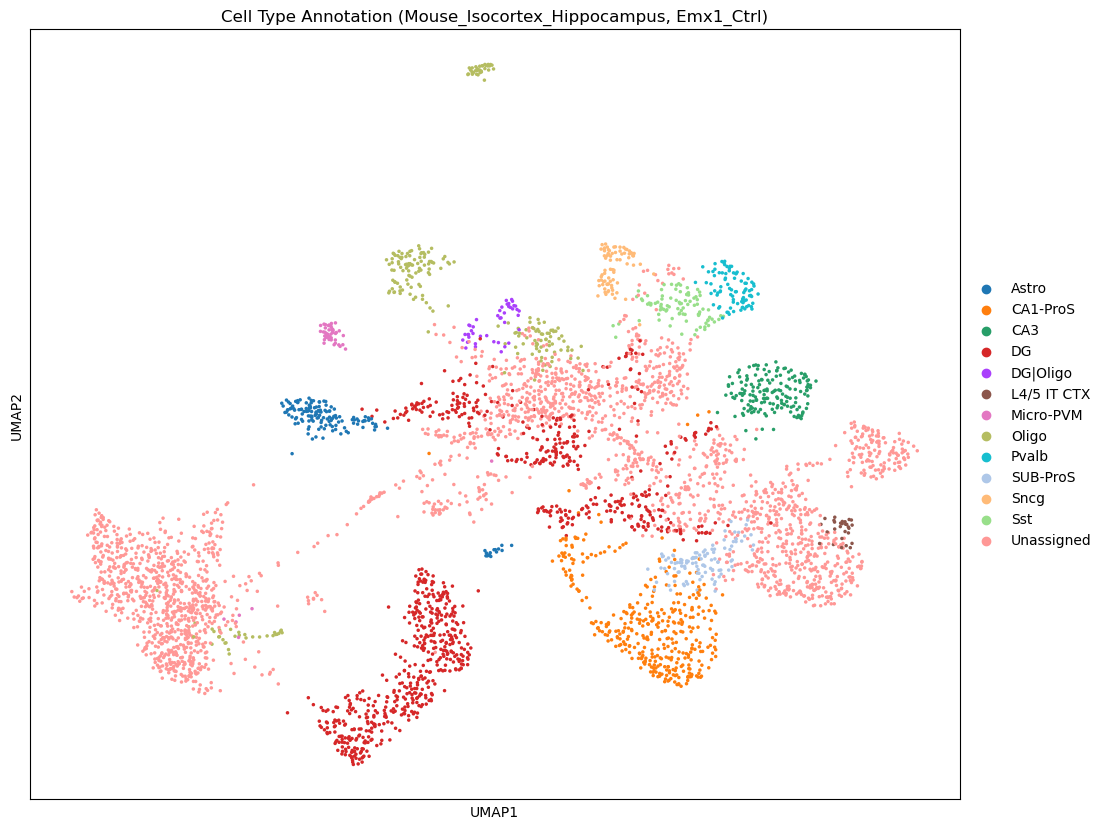

Saved cell type plot to results_Mouse_Isocortex_Hippocampus/Emx1_Ctrl_celltypes.png


<Figure size 640x480 with 0 Axes>

In [27]:
# Cell type annotation plot
if 'majority_voting' in adata_norm.obs.columns:
    fig, ax = plt.subplots(figsize=(12, 10))
    sc.pl.umap(adata_norm, color='majority_voting', ax=ax, legend_loc='right margin', 
                title=f"Cell Type Annotation ({sel_model}, {sel_sample})")
    plt.tight_layout()
    output_file = os.path.join(results_dir, f"{sel_sample}_celltypes.png")
    fig.savefig(output_file, dpi=150)
    print(f"Saved cell type plot to {output_file}")
    plt.show()
    plt.close(fig)

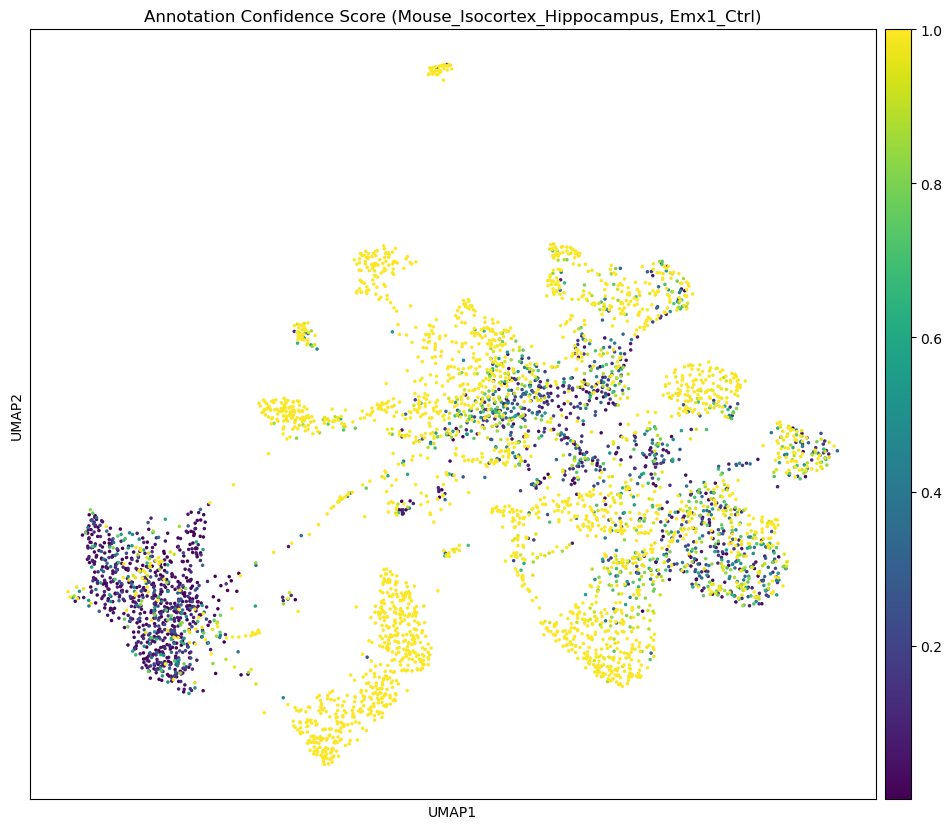

Saved confidence score plot to results_Mouse_Isocortex_Hippocampus/Emx1_Ctrl_confidence.png


<Figure size 640x480 with 0 Axes>

In [28]:
# Confidence score plot
if 'conf_score' in adata_norm.obs.columns:
    fig, ax = plt.subplots(figsize=(12, 10))
    sc.pl.umap(adata_norm, color='conf_score', ax=ax, 
                title=f"Annotation Confidence Score ({sel_model}, {sel_sample})", cmap='viridis')
    plt.tight_layout()
    output_file = os.path.join(results_dir, f"{sel_sample}_confidence.png")
    fig.savefig(output_file, dpi=150)
    print(f"Saved confidence score plot to {output_file}")
    plt.show()
    plt.close(fig)

In [29]:
# Get probability columns
prob_columns = [col for col in adata_norm.obs.columns if col.startswith('prob_')]

In [30]:
for i in range(0, len(prob_columns), 5):
    print("\t".join(prob_columns[i:i+5]))

prob_predicted_labels	prob_over_clustering	prob_majority_voting	prob_conf_score	prob_Astro
prob_CA1-ProS	prob_CA2-IG-FC	prob_CA3	prob_CR	prob_CT SUB
prob_Car3	prob_DG	prob_Endo	prob_L2 IT ENTl	prob_L2 IT ENTm
prob_L2/3 IT CTX	prob_L2/3 IT ENTl	prob_L2/3 IT PPP	prob_L2/3 IT RHP	prob_L3 IT ENT
prob_L4 RSP-ACA	prob_L4/5 IT CTX	prob_L5 IT CTX	prob_L5 PPP	prob_L5 PT CTX
prob_L5/6 IT TPE-ENT	prob_L5/6 NP CTX	prob_L6 CT CTX	prob_L6 IT CTX	prob_L6 IT ENTl
prob_L6b CTX	prob_L6b/CT ENT	prob_Lamp5	prob_Meis2	prob_Micro-PVM
prob_NP PPP	prob_NP SUB	prob_Oligo	prob_Pvalb	prob_SMC-Peri
prob_SUB-ProS	prob_Sncg	prob_Sst	prob_Sst Chodl	prob_VLMC
prob_Vip


In [31]:
# Find hippocampal and cortical cell types
hippo_cols = [col for col in prob_columns if any(term in col for term in hippo_suffix)]
cortex_cols = [col for col in prob_columns if any(term in col for term in cortical_suffix)]
other_cols = [col for col in prob_columns if col not in hippo_cols and col not in cortex_cols]

In [32]:
print(hippo_cols)
print(cortex_cols)
print(other_cols)

# %% [markdown]
# # Save data

output_file = os.path.join(results_dir, f"{sel_sample}_annotated.h5ad")
adata_norm.write(output_file)
print(f"Saved annotated data to {output_file}")

['prob_CA1-ProS', 'prob_CA2-IG-FC', 'prob_CA3', 'prob_DG', 'prob_SUB-ProS']
['prob_L2 IT ENTl', 'prob_L2 IT ENTm', 'prob_L2/3 IT CTX', 'prob_L2/3 IT ENTl', 'prob_L2/3 IT PPP', 'prob_L2/3 IT RHP', 'prob_L3 IT ENT', 'prob_L4 RSP-ACA', 'prob_L4/5 IT CTX', 'prob_L5 IT CTX', 'prob_L5 PPP', 'prob_L5 PT CTX', 'prob_L5/6 IT TPE-ENT', 'prob_L5/6 NP CTX', 'prob_L6 CT CTX', 'prob_L6 IT CTX', 'prob_L6 IT ENTl', 'prob_L6b CTX', 'prob_L6b/CT ENT']
['prob_predicted_labels', 'prob_over_clustering', 'prob_majority_voting', 'prob_conf_score', 'prob_Astro', 'prob_CR', 'prob_CT SUB', 'prob_Car3', 'prob_Endo', 'prob_Lamp5', 'prob_Meis2', 'prob_Micro-PVM', 'prob_NP PPP', 'prob_NP SUB', 'prob_Oligo', 'prob_Pvalb', 'prob_SMC-Peri', 'prob_Sncg', 'prob_Sst', 'prob_Sst Chodl', 'prob_VLMC', 'prob_Vip']


Saved annotated data to results_Mouse_Isocortex_Hippocampus/Emx1_Ctrl_annotated.h5ad


In [33]:
# Create masks for different brain regions
hippo_mask = adata_norm.obs['majority_voting'].astype(str).str.contains('|'.join(hippo_suffix), case=False)
cortex_mask = adata_norm.obs['majority_voting'].astype(str).str.contains('|'.join(cortical_suffix), case=False)

# Create AnnData objects for each region
adata_regions = {}

if hippo_mask.sum() > 0:
    print(f"Extracting {hippo_mask.sum()} hippocampal cells")
    adata_regions['hippocampus'] = adata_norm[hippo_mask].copy()
    
    # Calculate UMAP if needed
    if 'X_umap' not in adata_regions['hippocampus'].obsm:
        try:
            sc.pp.neighbors(adata_regions['hippocampus'])
            sc.tl.umap(adata_regions['hippocampus'])
        except:
            print("Could not calculate UMAP for hippocampal cells")

if cortex_mask.sum() > 0:
    print(f"Extracting {cortex_mask.sum()} cortical cells")
    adata_regions['cortex'] = adata_norm[cortex_mask].copy()
    
    # Calculate UMAP if needed
    if 'X_umap' not in adata_regions['cortex'].obsm:
        try:
            sc.pp.neighbors(adata_regions['cortex'])
            sc.tl.umap(adata_regions['cortex'])
        except:
            print("Could not calculate UMAP for cortical cells")

# Create a mask for the remaining cells
other_mask = ~(hippo_mask | cortex_mask)

if other_mask.sum() > 0:
    print(f"Extracting {other_mask.sum()} other cells")
    adata_regions['other'] = adata_norm[other_mask].copy()
    
    # Calculate UMAP if needed
    if 'X_umap' not in adata_regions['other'].obsm:
        try:
            sc.pp.neighbors(adata_regions['other'])
            sc.tl.umap(adata_regions['other'])
        except:
            print("Could not calculate UMAP for other cells")

Extracting 1558 hippocampal cells


Extracting 28 cortical cells


Extracting 3121 other cells


In [34]:
# Save region-specific data
for region, adata_region in adata_regions.items():
    output_path = os.path.join(results_dir, f"{region}_cells.h5ad")
    adata_region.write(output_path)
    print(f"{region.capitalize()} cells saved to {output_path}")

Hippocampus cells saved to results_Mouse_Isocortex_Hippocampus/hippocampus_cells.h5ad


Cortex cells saved to results_Mouse_Isocortex_Hippocampus/cortex_cells.h5ad


Other cells saved to results_Mouse_Isocortex_Hippocampus/other_cells.h5ad


In [35]:
# Generate a summary table of cell type annotations
cell_type_counts = adata_norm.obs['majority_voting'].value_counts()
cell_type_df = pd.DataFrame({
    'cell_type': cell_type_counts.index,
    'cell_count': cell_type_counts.values,
    'percentage': (cell_type_counts.values / cell_type_counts.sum() * 100).round(2)
})
cell_type_df = cell_type_df.sort_values('cell_count', ascending=False).reset_index(drop=True)

print(f"\nSummary of cell types for {sel_sample} using {sel_model} model:")
display(cell_type_df)


Summary of cell types for Emx1_Ctrl using Mouse_Isocortex_Hippocampus model:


,cell_type,cell_count,percentage
0,Unassigned,2436,51.75
1,DG,868,18.44
2,CA1-ProS,375,7.97
3,Oligo,232,4.93
4,CA3,167,3.55
5,Astro,149,3.17
6,SUB-ProS,105,2.23
7,Sst,90,1.91
8,Pvalb,87,1.85
9,Sncg,76,1.61


In [36]:
# Save summary to CSV
summary_file = os.path.join(results_dir, f"{sel_sample}_cell_type_summary.csv")
cell_type_df.to_csv(summary_file, index=False)
print(f"Saved cell type summary to {summary_file}")

Saved cell type summary to results_Mouse_Isocortex_Hippocampus/Emx1_Ctrl_cell_type_summary.csv


In [37]:
print(f"\n{'='*50}")
print(f"CELLTYPIST ANALYSIS COMPLETED")
print(f"{'='*50}")
print(f"Sample: {sel_sample}")
print(f"Model: {sel_model}")
print(f"Number of cells: {adata_norm.n_obs}")
print(f"Number of cell types identified: {len(cell_type_counts)}")
print(f"Results saved to: {os.path.abspath(results_dir)}")
print(f"{'='*50}")





CELLTYPIST ANALYSIS COMPLETED
Sample: Emx1_Ctrl
Model: Mouse_Isocortex_Hippocampus
Number of cells: 4707
Number of cell types identified: 13
Results saved to: /beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Linda_RNA/post_analysis/cell_typist/results_Mouse_Isocortex_Hippocampus
